# Imports

In [1]:
import os
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import datetime
os.chdir(r"C:\Users\macal\OneDrive\Documents\OMSCS\strategy_evaluation")
os.chdir(r"..")
from util import get_data
# from strategy_evaluation.indicators import BB_Pct, MACD, Stochastic_Oscillators, Golden_Cross, Death_Cross
from strategy_evaluation.indicators import BB_Pct_Digital, MACD_Digital, Stochastic_Oscillators_Digital
from strategy_evaluation.indicators import BB_Pct as bbpf, MACD as macdf, Stochastic_Oscillators as stocsf
from strategy_evaluation.marketsimcode import compute_portvals, create_holdings
os.chdir(r"strategy_evaluation")

# Helper Functions

In [2]:
def get_prices(dates, symbols):
    prices = get_data(symbols, dates) # Need SPY to drop non-trading days
    prices = prices.dropna(subset=["SPY"])[symbols] # Just to be safe, drop nan values in SPY and only take required symboles
    prices = prices.fillna(method="ffill").fillna(method="bfill") # Just to be safe, fill forward and backwards
    prices["Cash"] = 1.0
    return prices

In [3]:
def get_orders(prices,
               window = 20,
               lower_band = 0.03,
               upper_band = 1.00,
               fast = 12,
               slow = 26,
               signal_window = 9,
               macd_thresh = 0.7,
               k=14,
               d=4,
               overbought_thresh=0.75,
               oversold_thresh=0.2):
    symbol = prices.columns[0]
    bb = BB_Pct_Digital(prices = prices.drop(columns="Cash"), window = window, lower_band = lower_band, upper_band = upper_band)
    macd = MACD_Digital(prices = prices.drop(columns="Cash"), fast = fast, slow = slow, signal_window = signal_window, macd_thresh = macd_thresh)
    stocs = Stochastic_Oscillators_Digital(prices = prices.drop(columns="Cash"), k = k, d = d, overbought_thresh = overbought_thresh, oversold_thresh = oversold_thresh)
    indicators = pd.concat([bb, macd, stocs],axis = 1)
    signal = indicators.apply(lambda signals: most_common_signal(signals), axis = 1).to_frame()
    signal = signal.rename(columns={0:symbol})
    orders = signal[signal[symbol]!=0].copy()
    return orders
    

In [4]:
def most_common_signal(row):
    # Count the occurrences of each value in the row, ignoring zeros
    counts = row[row != 0].value_counts()
    if counts.empty:
        return 0  # if all values are zero, return 0
    if len(counts) > 1 and counts.iloc[0] == counts.iloc[1] and counts.index[0] == -counts.index[1]:
        return 0  # if there's a tie between -1 and 1, return 0
    return counts.idxmax()  # return the most common non-zero value

In [5]:
def buy_action(share_count:int):
    return 1000-share_count
def sell_action(share_count:int):
    return -1000 - share_count

In [6]:
def create_trades(prices, orders, sv, commission, impact):
    trades = pd.DataFrame(0.0, index=prices.index, columns=prices.columns)
    trades.loc[trades.index.min(),"Cash"] = sv
    symbol = prices.columns[0]
    for date,action in orders.iterrows():
        total_shares = trades.loc[:date,symbol].sum()
        value = prices.loc[date][symbol]
        if action[symbol] == 1:
            shares = buy_action(total_shares)
        if action[symbol] == -1:
            shares = sell_action(total_shares)
        cash = value * shares
        deductions = (cash * impact) + commission
        trades.loc[date,symbol] = trades.loc[date,symbol] + shares
        trades.loc[date,"Cash"] = trades.loc[date,"Cash"] + (-cash - deductions)
    return trades

In [7]:
def create_port_vals(start_date, end_date, symbol, sv, commission, impact):
    dates = pd.date_range(start_date, end_date)
    symbols = [symbol]
    prices = get_prices(dates,symbols)
    
    orders = get_orders(prices)
    
    trades = create_trades(prices, orders, sv, commission, impact)
    
    holdings = create_holdings(sv,trades)
    holdings = holdings.copy()
    values = prices * holdings
    port_vals = values.sum(axis=1)
    port_vals = port_vals/port_vals.iloc[0]
    return (orders, trades, holdings, values, port_vals)

In [8]:
def create_benchmark_port_vals(start_date, end_date, symbol, sv, commission, impact):
    dates = pd.date_range(start_date, end_date)
    symbols = [symbol]
    prices = get_prices(dates,symbols)
    
    orders = prices.iloc[[0]].drop(columns="Cash")
    orders[symbol] = 1
    
    trades = create_trades(prices, orders, sv, commission, impact)
    
    holdings = create_holdings(sv,trades)
    holdings = holdings.copy()
    values = prices * holdings
    port_vals = values.sum(axis=1)
    port_vals = port_vals/port_vals.iloc[0]
    return (orders, trades, holdings, values, port_vals)

In [9]:
def create_chart(symbol, trades, port_vals, bench_vals):
    buy_dates = [str(d.date()) for d in trades[trades[symbol]>0].index]
    sell_dates = [str(d.date()) for d in trades[trades[symbol]<0].index]

    fig, ax = plt.subplots()
    port_vals.plot(ax=ax, label = "Manual Strategy", color = "red")
    bench_vals.plot(ax=ax, label = "Benchmark", color = "purple")
    ax.legend()
    ax.set_title("Manual Strategy vs Benchmark")
    ax.set_xlabel("Date")
    ax.set_ylabel("Normalized Value")
    ax.grid(which="both", axis="x", linestyle=":", visible=True)

    y_min,y_max = ax.get_ylim()
    for line in buy_dates:
        ax.vlines(x=line,ymin=y_min,ymax=y_max, colors="blue",linestyles="dotted")
    for line in sell_dates:
        ax.vlines(x=line,ymin=y_min,ymax=y_max, colors="black",linestyles="dotted")

    plt.tight_layout()

In [10]:
def get_cr(port_val):
    """
    This function will return the cumulative return of a profile
    According to the lectures:
    Cumulative Return = (port_val[-1]/port_val[0]) - 1

    :param port_val: A pandas DataFrame object that contains the portfolio value
    :type port_val: pd.DataFrame
    :return: A pandas DataFrame object that represents the cumulative return values of the portfolio
    :rtype: pd.DataFrame
    """
    cr = (port_val.iloc[-1] / port_val.iloc[0]) - 1
    return cr

def get_daily_rets(port_val):
    """
    This function will return the average daily return of a profile
    According to the lectures:
    daily_rets = (df[1:]/df[:-1].values)-1
    Or in other words, today's value / yesterday's value

    :param port_val: A pandas DataFrame object that contains the portfolio value
    :type port_val: pd.DataFrame
    :return: A pandas DataFrame object that represents the daily return values of the portfolio
    :rtype: pd.DataFrame
    """
    daily_rets = (port_val / port_val.shift(1)) - 1
    return daily_rets

def get_adr(port_val):
    """
    This function will return the average daily return of a profile
    According to the lectures:
    Average Daily Return = daily_rets.mean()

    :param port_val: A pandas DataFrame object that contains the portfolio value
    :type port_val: pd.DataFrame
    :return: A float that is equal to the average values of the portfolio
    :rtype: float
    """
    daily_rets = get_daily_rets(port_val)
    adr = daily_rets.mean()
    return adr

def get_sddr(port_val):
    """
    This function will return the Standard Deviation of Daily Return of a profile
    According to the lectures:
    Standard Deviation of Daily Return = daily_rets.std()
    Note: We need sample standard deviation (Thank you Andrew Rife)

    :param port_val: A pandas DataFrame object that contains the portfolio value
    :type port_val: pd.DataFrame
    :return: A float that is equal to the standard deviation values of the portfolio
    :rtype: float
    """
    daily_rets = get_daily_rets(port_val)
    sddr = np.std(daily_rets,ddof=1)
    return sddr

def get_sr(port_val, risk_free_rate = 0):
    """
    This function will return the Sharpe Ratio of a profile

    :param port_val: A pandas DataFrame object that contains the portfolio value
    :type port_val: pd.DataFrame
    :param risk_free_rate: A float that represents the risk-free rate used in the Sharpe Ratio Calculation
    :type risk_free_rate: float
    :return: The Sharpe Ratio of the portfolio provided
    :rtype: float
    """
    sr = ((get_adr(port_val)-risk_free_rate) / get_sddr(port_val))*math.sqrt(252)
    return sr

In [11]:
def create_table(in_port_vals, oos_port_vals, rfr=0):
    # In Sample Results
    cr = get_cr(in_port_vals)
    adr = get_adr(in_port_vals)
    sddr = get_sddr(in_port_vals)
    sr = get_sr(in_port_vals, risk_free_rate = rfr)
    # Out of Sample Results
    oos_cr = get_cr(oos_port_vals)
    oos_adr = get_adr(oos_port_vals)
    oos_sddr = get_sddr(oos_port_vals)
    oos_sr = get_sr(oos_port_vals, risk_free_rate = rfr)
    
    # Table Data Dictionary
    data = {
        "IS":[cr,adr,sddr,sr],
        "OOS":[oos_cr,oos_adr,oos_sddr,oos_sr],
    }
    
    # DataFrame
    results = pd.DataFrame(data)
    results.index = ["CumRet","AvgDR","StdDR","SR"]
    
    return results

# Initial Inputs

In [12]:
symbol = "JPM"
symbols = [symbol]
# The in-sample period is from January 1, 2008, to December 31, 2009. 
sd = datetime.datetime(2008,1,1)
ed = datetime.datetime(2009,12,31)
dates = pd.date_range(sd, ed)

# The out-of-sample/testing period is from January 1, 2010, to December 31, 2011. 
oos_sd = datetime.datetime(2010,1,1)
oos_ed = datetime.datetime(2011,12,31)
oos_dates = pd.date_range(oos_sd, oos_ed)

impact=0.0
commission=0.0
sv=10_000

# Function Trial In Sample

In [13]:
prices = get_prices(dates, symbols)

In [14]:
(in_orders, in_trades, in_holdings, in_values, in_port_vals) = create_port_vals(sd,ed,symbol,sv,commission,impact)
(b_in_orders, b_in_trades, b_in_holdings, b_in_values, b_in_port_vals) = create_benchmark_port_vals(sd,ed,symbol,sv,commission,impact)

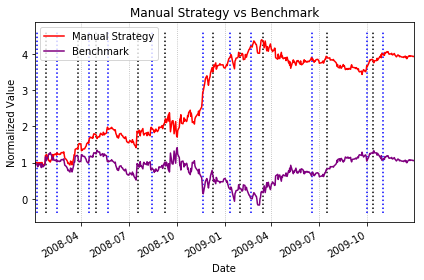

In [15]:
create_chart(symbol, in_trades, in_port_vals, b_in_port_vals)

# Functional Trial Out of Sample

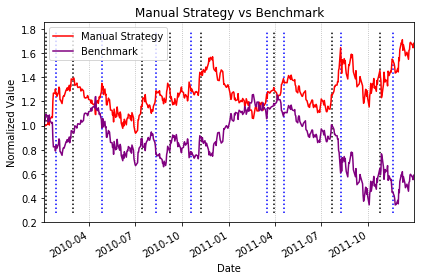

In [16]:
(oos_orders, oos_trades, oos_holdings, oos_values, oos_port_vals) = create_port_vals(oos_sd,oos_ed,symbol,sv,commission,impact)
(b_oos_orders, b_oos_trades, b_oos_holdings, b_oos_values, b_oos_port_vals) = create_benchmark_port_vals(oos_sd,oos_ed,symbol,sv,commission,impact)
create_chart(symbol, oos_trades, oos_port_vals, b_oos_port_vals)

In [17]:
create_table(in_port_vals, oos_port_vals, rfr=0)

,IS,OOS
CumRet,2.930500,0.672500
AvgDR,0.003450,0.001523
StdDR,0.038724,0.031806
SR,1.414423,0.760256


# Test Stuff

In [18]:
prices = get_data(symbols, dates) # Need SPY to drop non-trading days
prices = prices.dropna(subset=["SPY"])[symbols] # Just to be safe, drop nan values in SPY and only take required symboles
prices = prices.fillna(method="ffill").fillna(method="bfill") # Just to be safe, fill forward and backwards
prices["Cash"] = 1.0


In [19]:
bb = BB_Pct_Digital(prices = prices.drop(columns="Cash"), window = 20, lower_band = 0.03, upper_band = 1.0)
macd = MACD_Digital(prices = prices.drop(columns="Cash"), fast = 12, slow = 26, signal_window = 9, macd_thresh = 0.7)
stocs = Stochastic_Oscillators_Digital(prices = prices.drop(columns="Cash"), k=14, d=4, overbought_thresh=0.75, oversold_thresh=0.2)
indicators = pd.concat([bb, macd, stocs],axis = 1)

In [20]:
signal = indicators.apply(lambda signals: most_common_signal(signals), axis = 1).to_frame()
signal = signal.rename(columns={0:symbol})

In [21]:
orders = signal[signal[symbol]!=0].copy()

In [22]:
trades = pd.DataFrame(0.0, index=prices.index, columns=prices.columns)
symbol = prices.columns[0]
trades = prices.copy()
trades[symbol]=0
trades["Cash"]=0
for date,action in orders.iterrows():
    total_shares = trades.loc[:date,symbol].sum()
    value = prices.loc[date][symbol]
    if action[symbol] == 1:
        shares = buy_action(total_shares)
    if action[symbol] == -1:
        shares = sell_action(total_shares)
    cash = value * shares
    deductions = (cash * impact) + commission
    trades.loc[date,symbol]=shares
    trades.loc[date,"Cash"]= -cash - deductions
trades.loc[trades.index.min(),"Cash"] = sv

In [23]:
holdings = create_holdings(sv,trades)
holdings = holdings.copy()
values = prices * holdings
port_vals = values.sum(axis=1)

c:\Users\macal\miniconda3\envs\ml4t\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


# Strategy Stuff

In [24]:
prices = prices.drop(columns="Cash")

In [25]:
rets = prices
rets = rets.shift(-5)/rets

In [26]:
thresh = 0.08
ybuy=1 + thresh
ysell = 1 - thresh

conditions = [
    rets[symbol] > ybuy,
    rets[symbol] < ysell
]

# Define choices
choices = [1, -1]

# Create the new column 'result'
rets['result'] = np.select(conditions, choices, default=0)

In [27]:
np.random.seed(903687444)
from StrategyLearner import StrategyLearner

in_sd = datetime.datetime(2008,1,1)
in_ed = datetime.datetime(2009,12,31)
in_dates = pd.date_range(in_sd, in_ed)

Strat = StrategyLearner(impact=impact,commission=commission)
Strat.add_evidence(symbol = symbol, sd = in_sd, ed = in_ed, sv = sv, N = 5, ybuy=1.02, ysell=0.98)
in_trades = Strat.testPolicy_w_cash(symbol = symbol, sd = in_sd, ed = in_ed, sv = sv)
in_prices = StrategyLearner.get_prices(in_dates, symbols)
in_port_vals = StrategyLearner.create_port_vals(in_prices, in_trades, sv)
get_sr(in_port_vals)

c:\Users\macal\OneDrive\Documents\OMSCS\strategy_evaluation\StrategyLearner.py:253: RuntimeWarning: invalid value encountered in greater
  rets > (ybuy+impact),
c:\Users\macal\OneDrive\Documents\OMSCS\strategy_evaluation\StrategyLearner.py:254: RuntimeWarning: invalid value encountered in less
  rets < (ysell-impact)


2.6053640820801065

In [34]:
np.random.seed(903687444)
from scipy.optimize import minimize

def objective(params):
    N, ybuy, ysell = int(round(params[0])), params[1], params[2]
    Strat = StrategyLearner(impact=impact, commission=commission)
    Strat.add_evidence(symbol=symbol, sd=in_sd, ed=in_ed, sv=sv, N=N, ybuy=ybuy, ysell=ysell)
    in_trades = Strat.testPolicy_w_cash(symbol=symbol, sd=in_sd, ed=in_ed, sv=sv)
    in_prices = StrategyLearner.get_prices(in_dates, symbols)
    in_port_vals = StrategyLearner.create_port_vals(in_prices, in_trades, sv)
    sr = get_sr(in_port_vals)
    return -sr

# Bounds for each parameter
bounds = [(5, 20), (1.01, 1.1), (0.9, 0.99)]

# Initial guess for the parameters
initial_guess = [5, 1.02, 0.98]

# Run the minimization
result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)

print('Optimized Parameters:', result.x)
print('Maximized Sharpe Ratio:', -result.fun)


Optimized Parameters: [5.         1.01999947 0.97999573]
Maximized Sharpe Ratio: 1.9485261138754604


In [35]:
np.random.seed(903687444)

def objective(params):
    N, ybuy, ysell = int(round(params[0])), params[1], params[2]
    Strat = StrategyLearner(impact=impact, commission=commission)
    Strat.add_evidence(symbol=symbol, sd=in_sd, ed=in_ed, sv=sv, N=N, ybuy=ybuy, ysell=ysell)
    in_trades = Strat.testPolicy_w_cash(symbol=symbol, sd=in_sd, ed=in_ed, sv=sv)
    in_prices = StrategyLearner.get_prices(in_dates, symbols)
    in_port_vals = StrategyLearner.create_port_vals(in_prices, in_trades, sv)
    sr = get_sr(in_port_vals)
    return -sr

# Bounds for each parameter
bounds = [(5, 20), (1.01, 1.1), (0.9, 0.99)]

# Initial guess for the parameters
initial_guess = [5, 1.02, 0.98]

# Run the minimization
result = minimize(objective, initial_guess, method='TNC', bounds=bounds)

print('Optimized Parameters:', result.x)
print('Maximized Sharpe Ratio:', -result.fun)


Optimized Parameters: [5.   1.02 0.98]
Maximized Sharpe Ratio: 2.701638840464073


In [36]:
np.random.seed(903687444)
from scipy.optimize import differential_evolution

# Define the objective function
def objective(params):
    N, ybuy, ysell = int(params[0]), params[1], params[2]  # N needs to be an integer
    
    # Instantiate StrategyLearner and perform operations as per your setup
    Strat = StrategyLearner(impact=impact, commission=commission)
    Strat.add_evidence(symbol=symbol, sd=in_sd, ed=in_ed, sv=sv, N=N, ybuy=ybuy, ysell=ysell)
    in_trades = Strat.testPolicy_w_cash(symbol=symbol, sd=in_sd, ed=in_ed, sv=sv)
    in_prices = StrategyLearner.get_prices(in_dates, symbols)
    in_port_vals = StrategyLearner.create_port_vals(in_prices, in_trades, sv)
    sr = get_sr(in_port_vals)
    
    return -sr  # Minimizing negative Sharpe Ratio to maximize Sharpe Ratio

# Define bounds for N, ybuy, and ysell
bounds = [(5, 20), (1.01, 1.1), (0.9, 0.99)]

# Run differential evolution
result = differential_evolution(objective, bounds, strategy='best1bin', maxiter=100, popsize=15, tol=0.01, mutation=(0.5, 1.5), recombination=0.7)

print('Optimized Parameters:', result.x)
print('Maximized Sharpe Ratio:', -result.fun)


c:\Users\macal\miniconda3\envs\ml4t\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 